In [955]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
from numpy import linalg
from scipy.linalg import expm
from scipy.optimize import fsolve
from scipy.special import comb
from tqdm import tqdm
import itertools

#sympy imports
import sympy as sp
from sympy import Matrix, symbols, sqrt
from sympy.physics.control.lti import TransferFunction
from sympy.parsing.mathematica import parse_mathematica
from sympy import var

#define constants
e = 1.602*10**(-19)#C
hbar = 1.054*10**(-34)#Js
h = hbar*2*np.pi
phi0 = hbar/2/e
np.set_printoptions(precision=7,suppress=True)


In [1016]:
#initialize sympy variables
Lj, wj, zr, wr, Cj, Cjr, Cr, Lr, Crs, Cc, Cg, R, phi,s = symbols('Lj wj zr wr Cj Cjr Cr Lr Crs Cc Cg R phi s')
# Define a function that sets small coefficients to zero
precision = 1e-13
def set_small_coeffs_to_zero(expr):
    return expr.xreplace({n: 0 for n in expr.atoms(sp.Number) if abs(n) < precision})

# Assign parameter values.
zr_value = 50 #Ohm
wr_value = 2*np.pi*7 #GHz
Cr_value = 1/(wr_value*zr_value) #nf
Lr_value = zr_value/(wr_value) #nH
Cj_value = 30*10**(-6) #nF
Crs_value = .845*10**(-6) #nF
Cjr_value = 10*10**(-6) #nF
Cg_value = .00001*10**(-6) #nF
R_value =3000 #Ohm
phi_value = np.pi/3



def wr_phi():
    return sp.tan(phi/2)/R/(Crs+Cg)/3

wr_value = np.float64(wr_phi().subs({phi:phi_value,Crs:Crs_value,Cg:Cg_value,R:R_value}))
Cr_value = 1/(wr_value*zr_value) #nf
Lr_value = zr_value/(wr_value) #nH
print(wr_value/2/np.pi)
print('Cr',Cr_value*1e6)
print('wyphi',np.tan(phi_value/2)/R_value/(Crs_value+Cg_value)/2/np.pi)
values = [zr_value, wr_value, Cr_value, Lr_value, Cj_value, Crs_value, Cjr_value, Cg_value, R_value, phi_value]
print(values)
print(wr_value/2/np.pi)
# Convert the list to a numpy array
values_array = np.array(values,dtype=np.float64)

# Save the array to a text file
np.savetxt("Mathematica-files/values.txt", values_array)
#now run the Mathematica file, then run all. 

12.082453887720636
Cr 263.44804552267993
wyphi 36.24736166316191
[50, 75.91629674200117, 0.0002634480455226799, 0.6586201138066998, 2.9999999999999997e-05, 8.45e-07, 9.999999999999999e-06, 1.0000000000000001e-11, 3000, 1.0471975511965976]
12.082453887720636


In [1009]:
with open("Mathematica-files/wjchiral.txt",'r') as file:# Mathematica gives us the frequency of wj that gives chiral dynamics
    wjstring = file.read()

wj_value = np.float64(parse_mathematica(wjstring))
print(wr_value/2/np.pi)
print(wj_value/2/np.pi)

12.082453887720636
11.528448724767717


## Loading the series matrix decomposition of Z

In [958]:
#now we read the output matrices from Mathematica
strings = ["A0","A1","A2","A3","A4","B1","B2","B3","B4","poles"]

list_strings = []
for string in strings:
    with open("Mathematica-files/"+string+".txt",'r') as file:
        list_strings.append(file.read())

dict_strings = dict(zip(strings,list_strings))

A0 = parse_mathematica(dict_strings["A0"])
A1 = parse_mathematica(dict_strings["A1"])
A2 = parse_mathematica(dict_strings["A2"])
A3 = parse_mathematica(dict_strings["A3"])
A4 = parse_mathematica(dict_strings["A4"])
B1 = parse_mathematica(dict_strings["B1"])
B2 = parse_mathematica(dict_strings["B2"])
B3 = parse_mathematica(dict_strings["B3"])
B4 = parse_mathematica(dict_strings["B4"])
poles = parse_mathematica(dict_strings["poles"])
print(poles)

A0 = Matrix(A0)
A1 = Matrix(A1)
A2 = Matrix(A2)
A3 = Matrix(A3)
A4 = Matrix(A4)
B1 = Matrix(B1)
B2 = Matrix(B2)
B3 = Matrix(B3)
B4 = Matrix(B4)
poles = Matrix(poles)
w1, w2, w3, w4 = -1j*poles[1], -1j*poles[2], -1j*poles[3], -1j*poles[4]
omegas = [w1,w2,w3,w4]

(0.0, 37.81904017675188*I, 40.414907425558106*I, 43.12852435591442*I, 127.74790606266936*I)


In [959]:
#we use those to define the impedance matrix in its Cauer form
Z = A0/s + (A1*s+B1)/(s**2+w1**2)+(A2*s+B2)/(s**2+w2**2)+(A3*s+B3)/(s**2+w3**2)+(A4*s+B4)/(s**2+w4**2)
print(Z.evalf(10))

ZacR = (A1*s)/(s**2+w1**2)+(A2*s)/(s**2+w2**2)+(A3*s)/(s**2+w3**2)+(A4*s)/(s**2+w4**2)
ZacNR = B1/(s**2+w1**2)+B2/(s**2+w2**2)+B3/(s**2+w3**2)+B4/(s**2+w4**2)
Zdc = A0/s

Matrix([[2.241456089*s/(s**2 + 16319.5275) + 5.825251346*s/(s**2 + 1860.069613) + 5.203417348*s/(s**2 + 1633.364742) + 4.205629256*s/(s**2 + 1430.2798) + 9090.909091/s, 5.825251346*s/(s**2 + 1860.069613) + (182.1213583 - 2.601708674*s)/(s**2 + 1633.364742) + (-2.102814628*s - 137.7438188)/(s**2 + 1430.2798) + (-1.120728044*s - 247.9788589)/(s**2 + 16319.5275), 5.825251346*s/(s**2 + 1860.069613) + (137.7438188 - 2.102814628*s)/(s**2 + 1430.2798) + (247.9788589 - 1.120728044*s)/(s**2 + 16319.5275) + (-2.601708674*s - 182.1213583)/(s**2 + 1633.364742)], [5.825251346*s/(s**2 + 1860.069613) + (137.7438188 - 2.102814628*s)/(s**2 + 1430.2798) + (247.9788589 - 1.120728044*s)/(s**2 + 16319.5275) + (-2.601708674*s - 182.1213583)/(s**2 + 1633.364742), 2.241456089*s/(s**2 + 16319.5275) + 5.825251346*s/(s**2 + 1860.069613) + 5.203417348*s/(s**2 + 1633.364742) + 4.205629256*s/(s**2 + 1430.2798) + 9090.909091/s, 5.825251346*s/(s**2 + 1860.069613) + (182.1213583 - 2.601708674*s)/(s**2 + 1633.364742) +

# Constructing the Scattering and define wj

In [1001]:
Smats = []
I3 = np.eye(3)

s_values = np.arange(wr_value-7,wr_value,1e-2/4)
for s_value in tqdm(s_values):
    Zs = np.array(Z.subs(s,1j*s_value),dtype=np.complex128)
    R0 = 500
    mat1 = np.linalg.inv(R0*I3+Zs)
    mat2 = Zs-R0*I3
    S = np.dot(mat1,mat2)
    Smats.append(S)

100%|██████████| 2800/2800 [00:30<00:00, 90.67it/s] 


In [1002]:
Smats = np.array(Smats)
print(Smats.shape)
print(Smats[0])

(2800, 3, 3)
[[-0.6199793-0.7845684j -0.0001249-0.006245j   0.0060702+0.0015338j]
 [ 0.0060702+0.0015338j -0.6199793-0.7845684j -0.0001249-0.006245j ]
 [-0.0001249-0.006245j   0.0060702+0.0015338j -0.6199793-0.7845684j]]


6.761267585362157


(0.0, 1.05)

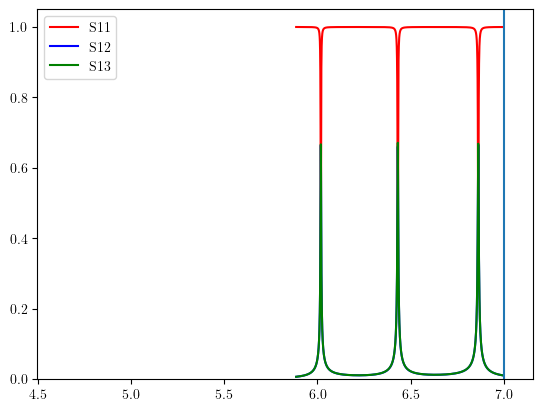

In [1003]:
fig, ax = plt.subplots()

ax.plot(s_values/2/np.pi, np.abs(Smats[:,0,0]),label='S11',color='red')
ax.plot(s_values/2/np.pi, np.abs(Smats[:,0,1]),label='S12',color='blue')
ax.plot(s_values/2/np.pi, np.abs(Smats[:,0,2]),label='S13',color='green')

print(wr_value/2/np.pi-1.5/2/np.pi)
x0 = np.float64(wr_value/2/np.pi-2/2/np.pi)
x1 = np.float64(wr_value/2/np.pi-0/2/np.pi)
x0 = np.float64((wj_value-1)/2/np.pi)
x1 = np.float64((wr_value+1)/2/np.pi)
ax.plot([wr_value/2/np.pi,wr_value/2/np.pi],[0,1.5])
ax.legend()
ax.set_xlim(x0,x1)
ax.set_ylim(0,1.05)

In [963]:
min_value = np.min(np.abs(Smats[:,0,0]))
min_index = np.argmin(np.abs(Smats[:,0,0]))

print("Minimum value is:", min_value)
print("Index of minim3um value is:", s_values[min_index])

S11, S12, S13 = [],[],[]
for i in range(len(Smats)):
    Si = Smats[i]
    S11.append(Si[0,0])
    S12.append(Si[0,1])
    S13.append(Si[0,2])

S11 = np.array(S11)
S12 = np.array(S12)
S13 = np.array(S13)

Minimum value is: 0.4099091508992556
Index of minim3um value is: 43.08688015322177


In [964]:
# # np.save("Plots/S/S11_almost_chiral",S11)
# # np.save("Plots/S/S12_almost_chiral",S12)
# # np.save("Plots/S/S13_almost_chiral",S13)
# # np.save("Plots/S/s_values_almost_chiral",s_values)
# # np.save("Plots/S/wr_almost_chiral",wr_value)
# np.save("Plots/S/S11_chiral",S11)
# np.save("Plots/S/S12_chiral",S12)
# np.save("Plots/S/S13_chiral",S13)
# np.save("Plots/S/s_values_chiral",s_values)
# np.save("Plots/S/wr_chiral",wr_value)

# # # np.save("Plots/S/S11_example",S11)
# # # np.save("Plots/S/S12_example",S12)
# # # np.save("Plots/S/S13_example",S13)
# # # np.save("Plots/S/s_values_example",s_values)
# # # np.save("Plots/S/wj_wr_example",np.array([wj_value,wr_value]))

# Plotting for the paper

In [965]:
#colors
v_yellow = '#FDE725'
v_yellow2 = '#d0e11c'
v_pear = '#B5DE2B'
v_mint = '#35B779'
v_mblue = '#3E4989'
v_blue = '#482878'
v_russian = '#440154'
v_ll = '#31688E'

a_green = '#3CBD78' 
a_green2 = '#9FBB4A'
a_blue = '#3A68B7' 
a_brown = '#8D5A39'
a_brown2 = '#863033'
a_blue2 = '#44A9B1'

def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

from matplotlib import rc
import matplotlib.pylab as plt

In [966]:
S11_chiral = np.load("Plots/S/S11_chiral.npy")
S12_chiral = np.load("Plots/S/S12_chiral.npy")
S13_chiral = np.load("Plots/S/S13_chiral.npy")
S11_almost_chiral = np.load("Plots/S/S11_almost_chiral.npy")
S12_almost_chiral = np.load("Plots/S/S12_almost_chiral.npy")
S13_almost_chiral = np.load("Plots/S/S13_almost_chiral.npy")
S11_example = np.load("Plots/S/S11_example.npy")
S12_example = np.load("Plots/S/S12_example.npy")
S13_example = np.load("Plots/S/S13_example.npy")
s_values_chiral = np.load("Plots/S/s_values_chiral.npy")
s_values_almost_chiral = np.load("Plots/S/s_values_almost_chiral.npy")
s_values_example = np.load("Plots/S/s_values_example.npy")
wj_wr_example = np.load("Plots/S/wj_wr_example.npy")
wj_example, wr_example =wj_wr_example[0], wj_wr_example[1]
wr_almost_chiral = np.load("Plots/S/wr_almost_chiral.npy")
wr_chiral = np.load("Plots/S/wr_chiral.npy")

7.0
wr_chiral 36.247361663161904


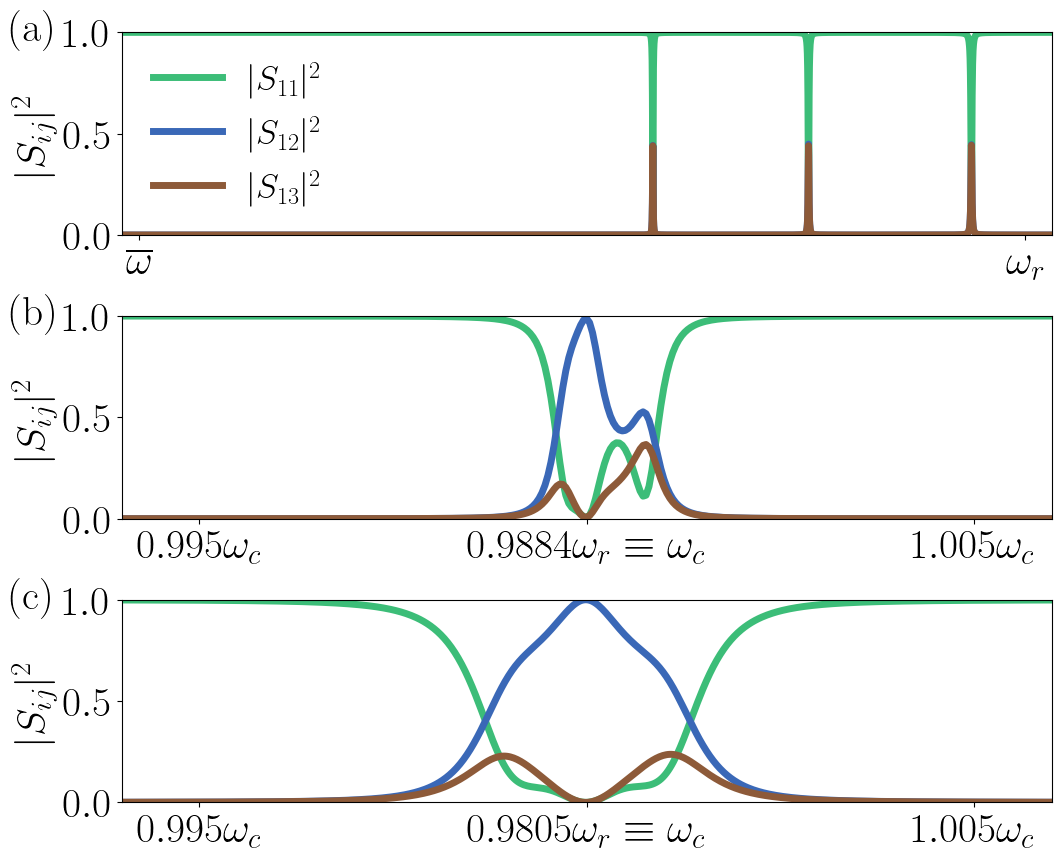

In [1006]:
rc('text', usetex=True)
# plt.rcParams["font.family"] = "serif"
# plt.rcParams["font.serif"] = "Computer Modern"
# rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
# rc('text', usetex=False)

fig= plt.figure(figsize=[12,10])
gs = fig.add_gridspec(3, 1, hspace=0.4, wspace=0.1)
ax1, ax2, ax3 = gs.subplots(sharex=False)

ax1.plot(s_values_example/2/np.pi, np.abs(S11_example)**2,label='$|S_{11}|^2$',color=a_green,lw=5)
ax1.plot(s_values_example/2/np.pi, np.abs(S13_example)**2,label='$|S_{12}|^2$',color=a_blue,lw=5)
ax1.plot(s_values_example/2/np.pi, np.abs(S12_example)**2,label='$|S_{13}|^2$',color=a_brown,lw=5)
ax1.set_ylim(0,1.0)

ax1.set_xticks([wj_example/2/np.pi,wr_example/2/np.pi])
ax1.set_yticks([0,0.5,1])
ax1.set_xticklabels([r'$\overline{\omega}$',r'$\omega_{r}$'])
ax1.tick_params(axis='both', which='major', labelsize=30)
ax1.set_ylabel(r'$|S_{ij}|^2$',fontsize=30)
ax1.legend(loc='center left',fontsize=25,frameon=False)
ax1.text(-.12, .96, r'(a)', transform=ax1.transAxes, size=30, weight='normal')
ax1.set_xlim(.99*wj_example/2/np.pi,1.01*wr_example/2/np.pi)

ax2.plot(s_values_almost_chiral/2/np.pi, np.abs(S11_almost_chiral)**2,label='$|S_{11}|^2$',color=a_green,lw=5)
ax2.plot(s_values_almost_chiral/2/np.pi, np.abs(S13_almost_chiral)**2,label='$|S_{12}|^2$',color=a_blue,lw=5)
ax2.plot(s_values_almost_chiral/2/np.pi, np.abs(S12_almost_chiral)**2,label='$|S_{13}|^2$',color=a_brown,lw=5)
ax2.set_ylim(0,1.0)

min_value = np.min(np.abs(S11_almost_chiral))
min_index = np.argmin(np.abs(S11_almost_chiral))
wchiral = s_values_almost_chiral[min_index]
print(wr_almost_chiral/2/np.pi)
ax2.set_xlim(.994*wchiral/2/np.pi,1.006*wchiral/2/np.pi)
ax2.set_xticks([.995*wchiral/2/np.pi,wchiral/2/np.pi,1.005*wchiral/2/np.pi])
ax2.set_yticks([0,0.5,1])
ax2.set_xticklabels([r'$0.995\omega_{c}$',r'$0.9884\omega_{r}\equiv \omega_c$',r'$1.005\omega_{c}$'])
ax2.tick_params(axis='both', which='major', labelsize=30)
ax2.set_ylabel(r'$|S_{ij}|^2$',fontsize=30)
# ax2.legend(loc='center left',fontsize=20,frameon=False)
ax2.text(-.12, .96, r'(b)', transform=ax2.transAxes, size=30, weight='normal')


ax3.plot(s_values_chiral/2/np.pi, np.abs(S11_chiral)**2,label='$|S_{11}|^2$',color=a_green,lw=5)
ax3.plot(s_values_chiral/2/np.pi, np.abs(S13_chiral)**2,label='$|S_{12}|^2$',color=a_blue,lw=5)
ax3.plot(s_values_chiral/2/np.pi, np.abs(S12_chiral)**2,label='$|S_{13}|^2$',color=a_brown,lw=5)
ax3.set_ylim(0,1.0)

min_value = np.min(np.abs(S11_chiral))
min_index = np.argmin(np.abs(S11_chiral))
wchiral = s_values_chiral[min_index]
print('wr_chiral',3*wr_chiral/2/np.pi)
ax3.set_xlim(.994*wchiral/2/np.pi,1.006*wchiral/2/np.pi)
ax3.set_xticks([.995*wchiral/2/np.pi,wchiral/2/np.pi,1.005*wchiral/2/np.pi])
ax3.set_yticks([0,0.5,1])
ax3.set_xticklabels([r'$0.995\omega_{c}$',r'$0.9805\omega_{r}\equiv \omega_c$',r'$1.005\omega_{c}$'])
ax3.tick_params(axis='both', which='major', labelsize=30)
ax3.set_ylabel(r'$|S_{ij}|^2$',fontsize=30)
# ax3.legend(loc='center left',fontsize=20,frameon=False)
ax3.text(-.12, .96, r'(c)', transform=ax3.transAxes, size=30, weight='normal')
# ax3.set_xlabel(r'$\omega/2\pi$ (MHz)',fontsize=25)
plt.savefig('Plots/S/scattering.pdf',bbox_inches='tight')
plt.show()

